# Running MAGIC and PHATE on Immunometabolism dataset
**Author:** Scott Campit

# Summary
This notebook performs data imputation using MAGIC for single-cell COBRA analyses.

To visualize the results, we will use PHATE, which was also developed in the same lab.

In [ ]:
#!pip install --user magic-impute
#!pip install --user phate
import magic
import phate
import scprep

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Read excel files
import xlrd
import openpyxl
from openpyxl import load_workbook

import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

# 1. Import data
First, let's import the immunometabolism data. I saved the data as an excel file where each sheet is a different cell lineage. The rows correspond to individual genes. The columns correspond to different time points.

In [143]:
# ACLX
#datapath = r"C:\Users\scott\Data\scRNASeq\shea\celldf.xlsx"

# Dell
datapath = r"D:\Data\scRNASeq\shea\celldf_ensembl.xlsx"


wb = load_workbook(filename=datapath, read_only=True)
print(wb.sheetnames)

['Stromal', 'AlveolarMacrophages', 'Macrophages', 'Monocytes', 'Pneumocytes', 'Bcells', 'Granulocytes', 'Tcells', 'Dendritic', 'Neutrophils', 'NK', 'Endothelial', 'HSC']


Let's get the original IDs, which are the column names in the `lung.csv` file. I need those to map back metabolic fluxes to the original dimension reduction plots.

In [120]:
#datapath = r"D:\Data\scRNASeq\shea\lung.csv"
#counts2 = pd.read_csv(datapath, delimiter=',')

# 2. Analyze Neutrophil data specifically
Let's write up some code to preprocess the dataset. We'll analyze the Neutrophil dataset first, because that's the main dataset of interest.

In [161]:
counts2 = pd.read_excel(datapath, 
                       sheet_name=wb.sheetnames[9])

In [180]:
print(counts2.head(10))

Gene.stable.ID     ENSG00000162929  ENSG00000168887  ENSG00000154274  \
Neutrophils  0                 0.0              0.0              0.0   
Neutrophils  14                0.0              0.0              0.0   
Neutrophils  14.1              0.0              0.0              0.0   
Neutrophils  14.2              0.0              0.0              0.0   
Neutrophils  14.3              0.0              0.0              0.0   
Neutrophils  14.4              0.0              0.0              0.0   
Neutrophils  14.5              0.0              0.0              0.0   
Neutrophils  14.6              0.0              0.0              0.0   
Neutrophils  14.7              0.0              0.0              0.0   
Neutrophils  14.8              0.0              0.0              0.0   

Gene.stable.ID     ENSG00000110696  ENSG00000171159  ENSG00000197620  \
Neutrophils  0            0.000000              0.0              0.0   
Neutrophils  14           0.000000              0.0            

First, let's grab the metadata we need.

In [163]:
# Drop symbols
ids = counts2["Gene.stable.ID"]
counts2 = counts2.drop(['MGI.symbol', 
                      'HGNC.symbol', 
                      'NCBI.gene..formerly.Entrezgene..ID', \
                      'Gene.stable.ID',
                      'Ensembl'], axis=1)

# Grab cell names
celltype = counts2.columns

Then let's print the resulting dataframe.

In [164]:
print(counts2.head())

   Neutrophils  0  Neutrophils  14  Neutrophils  14.1  Neutrophils  14.2  \
0               0                0                  0                  0   
1               0                0                  0                  0   
2               0                0                  0                  0   
3               0                0                  0                  0   
4               0                0                  0                  0   

   Neutrophils  14.3  Neutrophils  14.4  Neutrophils  14.5  Neutrophils  14.6  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   Neutrophils  14.7  Neutrophils  14.8  ...  Neutrophil

The data is current arranged where the rows are genes and the columns are cell lines. Let's transpose the matrix so that columns are genes and rows are cell lines.

In [165]:
counts2 = counts2.transpose()
counts2 = counts2.reset_index()
counts2 = counts2.drop('index', axis=1)

Set the columns to be gene symbols

In [166]:
counts2.columns = ids
counts2.index = celltype
print(counts2.head())

Gene.stable.ID     ENSG00000162929  ENSG00000161939  ENSG00000258315  \
Neutrophils  0                   0                0                0   
Neutrophils  14                  0                0                0   
Neutrophils  14.1                0                0                0   
Neutrophils  14.2                0                0                0   
Neutrophils  14.3                0                0                0   

Gene.stable.ID     ENSG00000168887  ENSG00000154274  ENSG00000248713  \
Neutrophils  0                   0                0                0   
Neutrophils  14                  0                0                0   
Neutrophils  14.1                0                0                0   
Neutrophils  14.2                0                0                0   
Neutrophils  14.3                0                0                0   

Gene.stable.ID     ENSG00000110696  ENSG00000171159  ENSG00000197620  \
Neutrophils  0                   0                0           

# 2. Data Preprocessing on a Single Cell Lineage
Let's now perform some data filtering.

## 2a. Filtering by library size
The library size of a cell is the number of unique mRNA molecules in the cell. As an arbitrary threshold, we will remove all cells that have fewer than 500 reads per cell.

<AxesSubplot:xlabel='Library size', ylabel='Number of cells'>

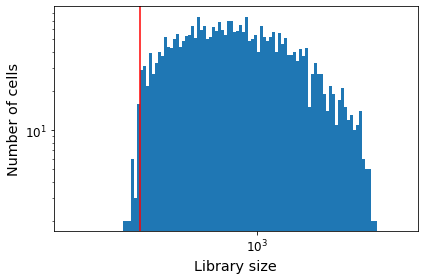

In [167]:
scprep.plot.plot_library_size(data=counts2,
                              cutoff=250)

<AxesSubplot:xlabel='Library size', ylabel='Number of cells'>

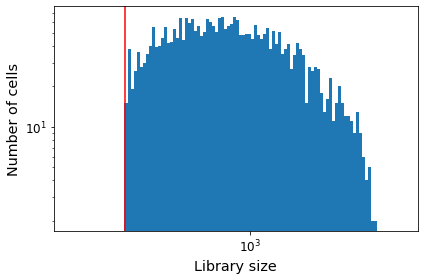

In [168]:
# be sure to uncomment this, unless your data is pre-filtered
counts2 = scprep.filter.filter_library_size(counts2, cutoff=250)
scprep.plot.plot_library_size(data=counts2,
                              cutoff=250)

## 2b. Filtering lowly expressed genes
Now let's filter lowly expressed genes. First, we'll get a count of the number of genes that are expressed in each cell.

In [169]:
genes_per_cell = np.sum(counts2 > 0, axis=0)

Then, let's visualize the data. There are several genes showing very little expression. We'll remove rarely-expressed genes.

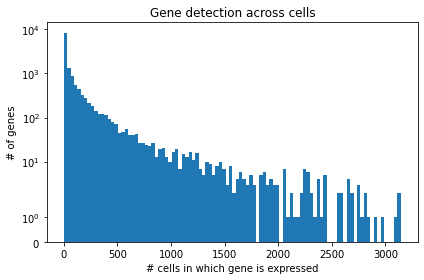

In [170]:
fig, ax = plt.subplots(1, figsize=(6,4))
ax.hist(genes_per_cell, bins=100)
ax.set_xlabel('# cells in which gene is expressed')
ax.set_ylabel('# of genes')
ax.set_yscale('symlog')
ax.set_title('Gene detection across cells')
fig.tight_layout()

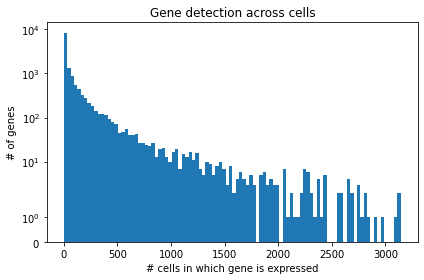

In [171]:
counts2 = scprep.filter.remove_rare_genes(counts2, cutoff=0, min_cells=5)
fig, ax = plt.subplots(1, figsize=(6,4))
ax.hist(genes_per_cell, bins=100)
ax.set_xlabel('# cells in which gene is expressed')
ax.set_ylabel('# of genes')
ax.set_yscale('symlog')
ax.set_title('Gene detection across cells')
fig.tight_layout()

In [172]:
print(counts2.shape)

(3146, 10236)


## 2c. Data normalization
Now let's normalize the data. First, we'll normalize the data by library size.

In [173]:
counts2 = scprep.normalize.library_size_normalize(counts2)

Then we'll transform the data using the square root.

<AxesSubplot:xlabel='Library size', ylabel='Number of cells'>

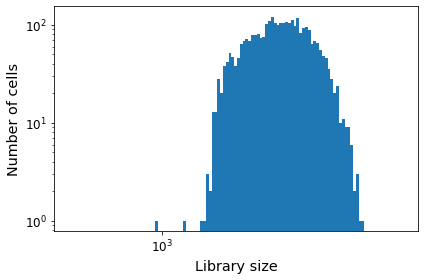

In [174]:
counts2 = scprep.transform.sqrt(counts2)
scprep.plot.plot_library_size(data=counts2)

In [179]:
label_map = pd.read_csv(r"D:/Data/scRNASeq/shea/neutrophil_colmap.csv")
label_map.index = label_map.final_col
print(label_map)
#merged_df = pd.merge(left=label_map, right=counts2, how='inner', left_on='final_col', right_index=True)
#print(merged_df.head())
#df.to_csv(r'D:\Data\scRNASeq\shea\filtered_neutrophils.csv')

#with open(r'D:\Data\scRNASeq\shea\filtered_neutrophils.txt', 'w') as f:
#    for item in orig_labels:
#        f.write("%s\n" % item)
#f.close()

                                orig_col        final_col
final_col                                                
Neutrophils  0    lung.h.d7_CATAGTCTGCCA   Neutrophils  0
Neutrophils  14  lung.d.d14_GTACCATGCTTN  Neutrophils  14
Neutrophils  14  lung.d.d14_ATTCAGACTTCC  Neutrophils  14
Neutrophils  14  lung.d.d14_TTGCACTGTCTN  Neutrophils  14
Neutrophils  14  lung.d.d14_GCGATGCTGCCA  Neutrophils  14
...                                  ...              ...
Neutrophils  21  lung.d.d21_GCCCCAAGTCGT  Neutrophils  21
Neutrophils  21  lung.d.d21_ACACTGTTTGCG  Neutrophils  21
Neutrophils  21  lung.d.d21_CCTTCCCTCCGG  Neutrophils  21
Neutrophils  21  lung.d.d21_TCCACTGCCACT  Neutrophils  21
Neutrophils  21  lung.d.d21_TGATGTCCTTGG  Neutrophils  21

[3175 rows x 2 columns]


In [ ]:
print(len(orig_labels))

# 3. Run MAGIC on a Single Cell Lineage
Now let's run MAGIC for data imputation with the normalized and filtered data.

In [ ]:
magic_op = magic.MAGIC()
nk_magic = magic_op.fit_transform(counts, genes="all_genes")

We can visualize the distribution of the imputed data.

In [ ]:
scprep.plot.plot_library_size(data=nk_magic)

In [ ]:
import seaborn as sns

In [ ]:
nk_magic = nk_magic.round(decimals=4)
print(nk_magic)

In [ ]:
#nk_magic.describe()
nk_magic[~np.isfinite(nk_magic)] = 0

Now let's make a heatmap of the data

In [ ]:
#nk_magic.index = time
sns.histplot(data=pd.melt(nk_magic),
             bins=100)

Now let's transform the normalized data into a robust Z-score and get a p-value out of it. We'll compute gene-wise Z-scores.

In [ ]:
from scipy.stats import median_absolute_deviation as mad
mu = nk_magic.median(axis=0)
n = nk_magic.shape[1]
med_abs_dev = mad(nk_magic)
scale_factor = 1.4826
Z = (nk_magic - mu) / (med_abs_dev * scale_factor)
print(Z)

Now let's plot the resulting distribution from taking the Z-score.

In [ ]:
Z[~np.isfinite(Z)] = 0
sns.histplot(data=pd.melt(Z),
             bins=100)

In [ ]:
from scipy.stats import norm
pval = norm.sf(abs(Z))*2 
print(pval.shape)
sns.histplot(data=pval.flatten(),
             bins=100)


In [ ]:
pval = pd.DataFrame(pval,
                    index=nk_magic.index,
                    columns=nk_magic.columns)

# 4. Run PHATE
Now let's perform dimension reduction.

In [ ]:
phate_op = phate.PHATE()
nk_phate = phate_op.fit_transform(nk_magic)

import seaborn as sns

fig, ax = plt.subplots(1, figsize=(4,4))
sns.kdeplot(nk_phate[:,0], 
            nk_phate[:,1], 
            n_levels=100, 
            shade=True, 
            cmap='inferno', 
            zorder=0, 
            ax=ax,
            cbar=True)

ax.set_xticks([])
ax.set_yticks([])

ax.set_xlabel('PHATE 1', fontsize=18)
ax.set_ylabel('PHATE 2', fontsize=18)

ax.set_title('KDE - NK Cells', fontsize=20)

fig.tight_layout()



# 4. Create a Function That Performs MAGIC Imputation for All Cell Types
Now that we have walked through the steps of a single lineage and found that the data distribution appears more "Normal", we can repeat this for all immune cell types. 

First, let's define a function to compute some robust standardized data using the robust Z-score method.

In [ ]:
from scipy.stats import median_absolute_deviation as mad
from scipy.stats import norm

def robust_zscore(df):
    """
    robust_zscore computes a modified version of the Z-score centered around the media and scaled by the median absolute deviation.
    INPUT:
      :param df: A data frame corresponding to numerical values where rows correspond to cells and columns correspond to genes.
    OUTPUTS:
      :output Z: A data frame of the robust Z-scores.
      :output pval: A data frame of the p-values corresponding to the robust Z-scores.

    """
    # Compute model parameters
    mu = df.median(axis=0)
    n = df.shape[1]
    med_abs_dev = mad(df)
    scale_factor = 1.4826

    # Compute robust Z-score
    Z = (df - mu) / (med_abs_dev * scale_factor)
    Z[~np.isfinite(Z)] = 0

    # Compute P-value based on Z-score
    pval = norm.sf(abs(Z))*2 
    pval = pd.DataFrame(pval,
                    index=df.index,
                    columns=df.columns)
    return(Z, pval)

Next, we'll define a function that runs the MAGIC pipeline described above.

In [ ]:
def MAGIC_pipeline(df):
    """
    MAGIC_pipeline performs data preprocessing, MAGIC imputation, and data standardization.
    INPUT: 
      :param df: A pandas dataframe of the raw counts data.
    OUTPUT:
      :param Z: A pandas dataframe of the Z-scores that reach a p-value threshold less than 0.05.
    """
    # Drop symbols
    df = df[df['NCBI.gene..formerly.Entrezgene..ID'].notna()]
    ids = df["NCBI.gene..formerly.Entrezgene..ID"]
    df = df.drop(['MGI.symbol', 
                  'HGNC.symbol', 
                  'NCBI.gene..formerly.Entrezgene..ID', 
                  'Gene.stable.ID',
                  'Ensembl'], axis=1)

    # Grab cell names
    celltype = df.columns

    # Annotate and configure data
    df = df.transpose()
    df = df.reset_index()
    df = df.drop('index', axis=1)
    df.columns = ids
    df.index = celltype

    # Perform some data filtering
    df = scprep.filter.filter_library_size(df, cutoff=250)
    df = scprep.filter.remove_rare_genes(df, cutoff=0, min_cells=5)

    # Perform count normalization and square root transformation.
    df = scprep.normalize.library_size_normalize(df)
    df = scprep.transform.sqrt(df)

    # Data imputation with MAGIC
    magic_op = magic.MAGIC()
    magic_data = magic_op.fit_transform(df, genes="all_genes")
    magic_data = magic_data.round(decimals=4)
    magic_data[~np.isfinite(magic_data)] = 0

    # Compute Z-scores
    Z, pvalue = robust_zscore(magic_data)
    Z[pvalue > 0.05] = np.NaN

    return(Z)

Finally, let's iterate this pipeline across all cell types. I ended up having to delete the cache for memory intensive purposes. Also, ensure the virtual environment is using the 64 bit version of Python, otherwise you will run into memory issues.

In [ ]:
for celltypes in wb.sheetnames: 
    counts = pd.read_excel(datapath, 
                        sheet_name=celltypes)
    Z = MAGIC_pipeline(counts)
    del counts

    # ACLX
    #Z.to_csv('C:/Users/scott/Analysis/Immune/'+celltypes+'_magic.csv')

    # Dell
    Z.to_csv('D:/Analysis/Immune/magic_entrez/'+celltypes+'_magic.csv')

    del Z